# Homework 2

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

In [2]:
# Import standard modules
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scheffer_quant.fixed_income.fi_pricing import *
from scheffer_quant.fixed_income.treasury import *
from scheffer_quant.fixed_income.curve_construction import *
from scheffer_quant.fixed_income.fi_cash_flows import *
from scheffer_quant.strategies.bond_pair_trading import *

In [4]:
# Global variables
COMPOUNDING_FREQ = 2

pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 100
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `KYTREASNO` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

In [7]:
FILE_DATE = '2015-08-15'
FILE_PATH =  f'../data/treasury_ts_{FILE_DATE}.xlsx'
ID_LONG = 204046
ID_SHORT = 204047
DATE0 = '2008-11-04'
DAYS_Y = 365.25

# Extract data:
data = pd.read_excel(FILE_PATH, sheet_name='database')
data_info = pd.read_excel(FILE_PATH, sheet_name='info', index_col=0)

data_filtered = data[(data['kytreasno'].isin([ID_LONG, ID_SHORT])) & (data['caldt'] == DATE0)].sort_values(by='caldt')
data_filtered.head(2)

,kytreasno,kycrspid,caldt,tdbid,tdask,tdnomprc,tdnomprc_flg,tdsourcr,tdaccint,tdretnua,tdyld,tdduratn,tdpubout,tdtotout,tdpdint,tdidxratio,tdidxratio_flg
4178,204047,20150815.2043,2008-11-04,105.9531,105.9844,105.9688,M,X,0.9355,0.0116,0.0001,2168.0166,20998.0000,32470.0000,0.0000,NaN,NaN
5834,204046,20150815.1106,2008-11-04,141.8594,141.8906,141.8750,M,X,2.3387,0.0097,0.0001,1910.3079,2852.0000,4024.0000,0.0000,NaN,NaN


## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

In [4]:
summary_data = get_summary_table(info=data_info, database=data, date=DATE0)
summary_data.drop(index=['clean price', 'issue date'], inplace=True)
print("Summary of bond and note data: on 2008-11-04")
summary_data

Summary of bond and note data: on 2008-11-04


KYTREASNO,204046,204047
maturity date,2015-08-15 00:00:00,2015-08-15 00:00:00
coupon rate,10.6250,4.2500
type,bond,note
tdbid,141.8594,105.9531
tdask,141.8906,105.9844
tdaccint,2.3387,0.9355
dirty price,144.2137,106.9042
duration,5.2301,5.9357
ytm,0.0358,0.0324
modified duration,5.1383,5.8412


## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use $\$1mm$ of capital, leveraged 50x to buy $\$50mm$ of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [5]:
ID_LONG = summary_data.loc['ytm'].astype('float64').idxmax()
ID_SHORT = summary_data.loc['ytm'].astype('float64').idxmin()
SIZE_ASSET_LONG = 50e6
EQUITY_RATIO = 1/50

financing = pd.DataFrame(dtype=float,index=[ID_LONG,ID_SHORT])
financing['haircut'] = [EQUITY_RATIO, EQUITY_RATIO]
# financing['repo'] = [.0015,.0010]
financing

,haircut
204046,0.0200
204047,0.0200


In [6]:
balance_sheet, fmt = trade_balance_sheet(
                                prices=summary_data.loc['dirty price'],
                                durations=summary_data.loc['duration'],
                                haircuts=financing['haircut'],
                                long_asset=SIZE_ASSET_LONG,
                                key_long=ID_LONG,
                                key_short=ID_SHORT)
balance_sheet.style.format(fmt)

,dirty price,dolar duration,equity,assets,contracts
204046,$144.21,$754.26,"$1,000,000.00","$50,000,000.00","346,707.81"
204047,$106.90,$634.55,"$-881,131.58","$-44,056,578.93","-412,112.66"


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.)

In [7]:
spread_convergence = 1 / 10000
pnl_spread_1bp, fmt_dict = pnl_spread_convergence(
                                    spread_convergence=spread_convergence,
                                    modified_duration=summary_data.loc['modified duration'],
                                    price=summary_data.loc['dirty price'],
                                    n_contracts=balance_sheet['contracts'])
pnl_spread_1bp.style.format(fmt_dict, na_rep='')



,ytm change,modified duration,price,DV01,num contracts,pnl
KYTREASNO,,,,,,
204046,-0.0050%,5.14,$144.21,0.07,"346,707.81","$12,845.71"
204047,0.0050%,5.84,$106.90,0.06,"-412,112.66","$12,867.14"
total,,,,,,"$25,712.85"


In [8]:
spread_convergence = summary_data.loc['ytm'].diff().dropna().abs().values[0]
pnl_spread_converges, fmt_dict = pnl_spread_convergence(
                                    spread_convergence=spread_convergence,
                                    modified_duration=summary_data.loc['modified duration'],
                                    price=summary_data.loc['dirty price'],
                                    n_contracts=balance_sheet['contracts'])
pnl_spread_converges.style.format(fmt_dict, na_rep='')

,ytm change,modified duration,price,DV01,num contracts,pnl
KYTREASNO,,,,,,
204046,-0.1695%,5.14,$144.21,0.07,"346,707.81","$435,509.58"
204047,0.1695%,5.84,$106.90,0.06,"-412,112.66","$436,236.08"
total,,,,,,"$871,745.67"


In [9]:
opportunity = pd.DataFrame([pnl_spread_converges.loc['total','pnl'], pnl_spread_1bp.loc['total','pnl']], columns=['pnl'],index=['converges','1bp'])
opportunity['return'] = opportunity['pnl'] / balance_sheet['equity'].abs().sum()
opportunity.style.format({'return':'{:.2%}','pnl':'${:,.2f}'})

,pnl,return
converges,"$871,745.67",46.34%
1bp,"$25,712.85",1.37%


<Axes: title={'center': 'YTM spread (bps)'}, xlabel='CALDT', ylabel='bps'>

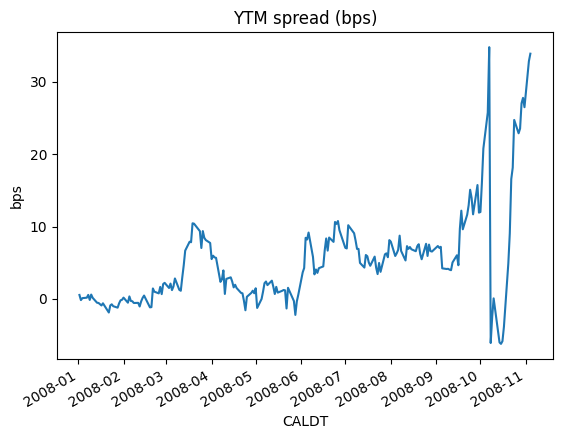

In [10]:
spread = get_spread_bps(database=data, id_ref=ID_LONG)

spread = spread.loc[:,f'({ID_LONG} - {ID_SHORT})']
spread.rename('ytm spread (bps)',inplace=True)
spread.loc['2008':'2008-11-04'].plot(ylabel='bps',title='YTM spread (bps)')

## 1.5 Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

In [11]:
n_weeks = 9
data_backtest = data[(data['KYTREASNO'].isin([ID_LONG, ID_SHORT]))]
data_backtest = data_backtest.assign(dirty_price=data_backtest['TDNOMPRC'] + data_backtest['TDACCINT'])
prices_ts = data_backtest.pivot_table(index='CALDT', columns='KYTREASNO', values='dirty_price')
durations_ts = data_backtest.pivot_table(index='CALDT', columns='KYTREASNO', values='TDDURATN')  / 365.25


trade, fmt_dict = trade_evolution(start_date=DATE0,
                                  date_maturity=summary_data.loc['maturity date',ID_SHORT],
                                  n_weeks=n_weeks,
                                  balsheet=balance_sheet,
                                  price_ts=prices_ts,
                                  duration_ts=durations_ts,
                                  financing=financing,
                                  cpn_rates=summary_data.loc['coupon rate'],
                                  key_long=ID_LONG,
                                  key_short=ID_SHORT)

summary = trade[['price change','coupons','total pnl']].join(spread,how='left')

fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
trade.iloc[::4,:].style.format(fmt,na_rep='')

,price change,coupons,total pnl,equity,margin call,capital paid in,return (init equity),return (avg equity)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,"$1,881,131.58",$0.00,"$1,881,131.58",0.00%,0.00%
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35","$1,985,898.84","$293,861.82","$2,838,732.45",-39.77%,-32.93%
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09","$2,037,802.21","$-36,872.99","$2,951,458.94",-40.24%,-28.98%


Text(0.5, 1.0, 'Total Profit & Loss vs YTM spread (bps)')

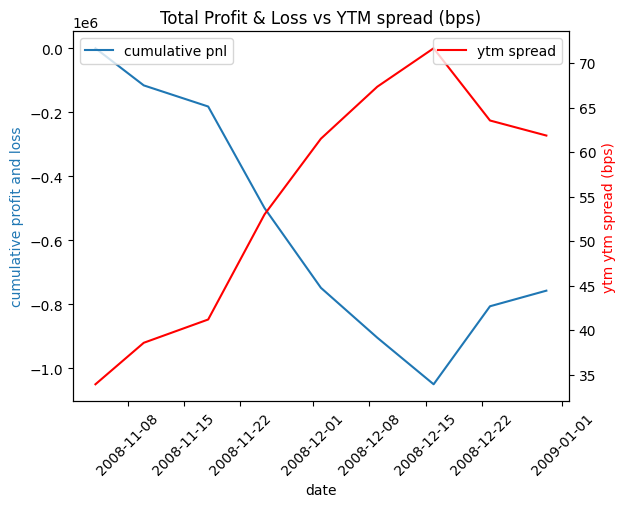

In [12]:
fig, ax = plt.subplots()

ax.plot(summary[['total pnl']])
ax.set_xlabel('date')
ax.set_ylabel('cumulative profit and loss',color=ax.get_lines()[-1].get_color())
ax.tick_params(axis='x', rotation=45)
ax.legend(['cumulative pnl'],loc=2)

ax2 = ax.twinx()
ax2.plot(summary[['ytm spread (bps)']], color='r')
ax2.set_ylabel('ytm ytm spread (bps)',color=ax2.get_lines()[-1].get_color())
ax2.legend(['ytm spread'],loc=1)

ax.set_title('Total Profit & Loss vs YTM spread (bps)')

### Conclusion:

Loses a ton! Loss is roughly what we expected to gain.
* Spread diverges ~35bps instead of converging ~35bps.
* So our estimated pnl response (via modified duration) to ytm spread is reasonable approximation.

<span style="color: red;">Notes from class:</span>
In the meantime:
- The repo rates keep increasing, reducing leverage considerably --> difficult to maintain the trade
    - Banks would also not be willing to invest in this trade because in a crisis, they are not willing to leverage more money and risk lose more.
    - There is no limit on paper on the amount you can lose holding this trade.
- Your long asset, which was used to fund the short through repo decreased value and now you have less money to borrow --> had to put more money in to maintain the trade

When is the spread big enough so that it justify the uncertainty of the time to converge, because we don't want to wait 7 years for the price to converge: **statistical arbitrage**


## Old version:

In [13]:
'''
SELECTED_DATES = ['2009-01-27', '2009-03-24', '2009-06-16']
data_backtest = data[(data['KYTREASNO'].isin([ID_LONG, ID_SHORT])) & (data['CALDT'] >= DATE0) & (data['CALDT'] <= '2009-06-30')]
data_backtest = data_backtest.assign(dirty_price=data_backtest['TDNOMPRC'] + data_backtest['TDACCINT'])

prices_ts = data_backtest.pivot_table(index='CALDT', columns='KYTREASNO', values='dirty_price')
durations_ts = data_backtest.pivot_table(index='CALDT', columns='KYTREASNO', values='TDDURATN')  / 365.25
cpn_cash_flows_ts = get_cash_flows(data=data_backtest, data_info=data_info, keys_list=[ID_LONG, ID_SHORT])

results_df, fmt = trade_backtest(
                prices_ts=prices_ts,
                durations_ts=durations_ts,
                key_long=ID_LONG,
                key_short=ID_SHORT,
                financing=financing,
                long_asset=SIZE_ASSET_LONG,
                pnl_freq="W",
                freq_num=1,
                maturity_dates=summary_data.loc['maturity date'],
                cpn_rates=summary_data.loc['coupon rate'],

            )
# FIlter indexes caldt = 2009-01-01, 2009-03-24, 2009-06-16:
display(results_df.loc[SELECTED_DATES].style.format(fmt, na_rep=''))]
'''

'\nSELECTED_DATES = [\'2009-01-27\', \'2009-03-24\', \'2009-06-16\']\ndata_backtest = data[(data[\'KYTREASNO\'].isin([ID_LONG, ID_SHORT])) & (data[\'CALDT\'] >= DATE0) & (data[\'CALDT\'] <= \'2009-06-30\')]\ndata_backtest = data_backtest.assign(dirty_price=data_backtest[\'TDNOMPRC\'] + data_backtest[\'TDACCINT\'])\n\nprices_ts = data_backtest.pivot_table(index=\'CALDT\', columns=\'KYTREASNO\', values=\'dirty_price\')\ndurations_ts = data_backtest.pivot_table(index=\'CALDT\', columns=\'KYTREASNO\', values=\'TDDURATN\')  / 365.25\ncpn_cash_flows_ts = get_cash_flows(data=data_backtest, data_info=data_info, keys_list=[ID_LONG, ID_SHORT])\n\nresults_df, fmt = trade_backtest(\n                prices_ts=prices_ts,\n                durations_ts=durations_ts,\n                key_long=ID_LONG,\n                key_short=ID_SHORT,\n                financing=financing,\n                long_asset=SIZE_ASSET_LONG,\n                pnl_freq="W",\n                freq_num=1,\n                maturit

In [14]:
''' 
spread_ytm_ts = get_spread_bps(database=data_backtest, id_ref=ID_LONG)
spread_diff_ts = spread_ytm_ts.diff()
ytm_ts = data_backtest.pivot_table(index='CALDT', columns='KYTREASNO', values='TDYLD')  / 365.25
modified_duration_ts = durations_ts * (1 + ytm_ts)

pnl_comparison = pd.DataFrame(results_df.loc[SELECTED_DATES, 'net pnl'])

for date in SELECTED_DATES:
    pnl_spread, fmt_dict = pnl_spread_convergence(
                                    spread_convergence=-spread_diff_ts.loc[date].values[0] / 2 / 10000,
                                    modified_duration=modified_duration_ts.loc[date],
                                    price=prices_ts.loc[date],
                                    n_contracts=results_df.loc[date, ['long', 'short']].rename(index={'long': ID_LONG, 'short': ID_SHORT}))
    pnl_comparison.loc[date, 'spread pnl'] = pnl_spread.loc['total', 'pnl']

pnl_comparison['$ difference'] = pnl_comparison['spread pnl'] - pnl_comparison['net pnl']

pnl_comparison.style.format('${:,.2f}')    
'''

" \nspread_ytm_ts = get_spread_bps(database=data_backtest, id_ref=ID_LONG)\nspread_diff_ts = spread_ytm_ts.diff()\nytm_ts = data_backtest.pivot_table(index='CALDT', columns='KYTREASNO', values='TDYLD')  / 365.25\nmodified_duration_ts = durations_ts * (1 + ytm_ts)\n\npnl_comparison = pd.DataFrame(results_df.loc[SELECTED_DATES, 'net pnl'])\n\nfor date in SELECTED_DATES:\n    pnl_spread, fmt_dict = pnl_spread_convergence(\n                                    spread_convergence=-spread_diff_ts.loc[date].values[0] / 2 / 10000,\n                                    modified_duration=modified_duration_ts.loc[date],\n                                    price=prices_ts.loc[date],\n                                    n_contracts=results_df.loc[date, ['long', 'short']].rename(index={'long': ID_LONG, 'short': ID_SHORT}))\n    pnl_comparison.loc[date, 'spread pnl'] = pnl_spread.loc['total', 'pnl']\n\npnl_comparison['$ difference'] = pnl_comparison['spread pnl'] - pnl_comparison['net pnl']\n\npnl_com

In [15]:
'''
results_df.index = pd.to_datetime(results_df.index, format='%Y-%m-%d')
prices_ts.index = pd.to_datetime(prices_ts.index, format='%Y-%m-%d')
cpn_cash_flows_ts.index = pd.to_datetime(cpn_cash_flows_ts.index, format='%Y-%m-%d')

results_df['unhedged pnl'] = results_df['long'].shift(1) * (prices_ts[ID_LONG].diff() + results_df['long cpn']).fillna(0)
results_df.rename(columns={'net pnl': 'net hedged pnl'}, inplace=True)

# Create figure with secondary y-axis
fig = go.Figure()

# -- Cumulative Hedged P&L Trace
fig.add_trace(
    go.Scatter(
        x=results_df.index,
        y=results_df['net hedged pnl'].cumsum(),
        mode='lines',
        name='Cumulative Hedged P&L',
        yaxis='y'
    )
)

# -- Cumulative Unhedged P&L Trace
fig.add_trace(
    go.Scatter(
        x=results_df.index,
        y=results_df['unhedged pnl'].cumsum(),
        mode='lines',
        name='Cumulative Unhedged P&L',
        yaxis='y'
    )
)

# -- Spread YTM Trace (on a secondary y-axis)
fig.add_trace(
    go.Scatter(
        x=spread_ytm_ts.index,
        y=spread_ytm_ts.iloc[:, 0],  # or specify the exact column if needed
        mode='lines',
        name='Spread YTM',
        yaxis='y2'
    )
)

# Update layout with dual y-axes
fig.update_layout(
    title=f'Cumulative P&L and Spread YTM between Bonds and Notes (ID: {ID_LONG} and {ID_SHORT})',
    xaxis=dict(
        title='Date',
        type='date'
    ),
    yaxis=dict(
        title='Cumulative P&L ($)',
        tickformat=",0f",
        zeroline=True,
        zerolinecolor='darkgray',
        zerolinewidth=1,
        gridcolor='lightgrey'
    ),
    yaxis2=dict(
        title='Spread YTM',
        overlaying='y',   # overlay the second y-axis on the first
        side='right'      # place it on the right
    ),
    legend=dict(
        x=0.5,
        y=-0.2,
        xanchor='center',
        yanchor='top',
        orientation='h',
        bordercolor="Gray",
        borderwidth=1
    )
)

# Show the figure
fig.show()
'''


'\nresults_df.index = pd.to_datetime(results_df.index, format=\'%Y-%m-%d\')\nprices_ts.index = pd.to_datetime(prices_ts.index, format=\'%Y-%m-%d\')\ncpn_cash_flows_ts.index = pd.to_datetime(cpn_cash_flows_ts.index, format=\'%Y-%m-%d\')\n\nresults_df[\'unhedged pnl\'] = results_df[\'long\'].shift(1) * (prices_ts[ID_LONG].diff() + results_df[\'long cpn\']).fillna(0)\nresults_df.rename(columns={\'net pnl\': \'net hedged pnl\'}, inplace=True)\n\n# Create figure with secondary y-axis\nfig = go.Figure()\n\n# -- Cumulative Hedged P&L Trace\nfig.add_trace(\n    go.Scatter(\n        x=results_df.index,\n        y=results_df[\'net hedged pnl\'].cumsum(),\n        mode=\'lines\',\n        name=\'Cumulative Hedged P&L\',\n        yaxis=\'y\'\n    )\n)\n\n# -- Cumulative Unhedged P&L Trace\nfig.add_trace(\n    go.Scatter(\n        x=results_df.index,\n        y=results_df[\'unhedged pnl\'].cumsum(),\n        mode=\'lines\',\n        name=\'Cumulative Unhedged P&L\',\n        yaxis=\'y\'\n    )\n)\n

***

# 2 Hedging Duration

Use data from `../data/treasury_ts_duration_2024-10-31.xlsx`.

The file contains time-series information on two treasuries. Observe the info of the securities with the following code:


In [16]:
QUOTE_DATE = '2024-10-31'
FILE_PATH = Path(settings.DATA_DIR) / f"treasury_ts_duration_{QUOTE_DATE}.xlsx"

# Extract data:
data = pd.read_excel(FILE_PATH, sheet_name='database')
data_info =  data.drop_duplicates(subset='KYTREASNO', keep='first').set_index('KYTREASNO')
data_info[['type','issue date','maturity date','cpn rate']]

,type,issue date,maturity date,cpn rate
KYTREASNO,,,,
207391,note,2019-08-15,2029-08-15,1.6250
207392,bond,2019-08-15,2049-08-15,2.2500


You will largely focus on the sheets which give the timeseries of prices and durations for each of the two securities, as shown in the following code.

In [17]:
price = pd.read_excel(FILE_PATH,sheet_name='price').set_index('quote date')
duration = pd.read_excel(FILE_PATH,sheet_name='duration').set_index('quote date')
first_date = duration.index[0]

display(price)
display(duration)

,207391,207392
quote date,,
2019-08-09,98.8828,99.7891
2019-08-12,99.7969,102.5547
2019-08-13,99.2812,101.8672
2019-08-14,100.4062,105.1797
2019-08-15,100.8828,106.2344
...,...,...
2024-11-22,88.7402,63.7227
2024-11-25,89.2871,65.3789
2024-11-26,89.2148,65.1758


,207391,207392
quote date,,
2019-08-09,9.2895,22.0001
2019-08-12,9.2855,22.1185
2019-08-13,9.2803,22.0843
2019-08-14,9.2828,22.2285
2019-08-15,9.2822,22.2709
...,...,...
2024-11-22,4.5394,17.2055
2024-11-25,4.5320,17.3123
2024-11-26,4.5291,17.2955


### 2.1.

Suppose you have a portfolio of `10,000` USD long in security `207391` on the first day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

In [18]:
SIZE_EQUITY_LONG = 10000
ID_LONG = 207391
ID_SHORT = 207392

In [19]:
short_position = SIZE_EQUITY_LONG * (duration.loc[first_date, ID_LONG] / duration.loc[first_date, ID_SHORT])
print(f'To hedge ${SIZE_EQUITY_LONG:,} in {ID_LONG}, short ${short_position:,.2f} in {ID_SHORT}.')

To hedge $10,000 in 207391, short $4,222.48 in 207392.


### 2.2.

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be `10,000`.
* Repeat throughout the timeseries.

Calculate the daily profit and loss (PnL) for the
* dynamically hedged position constructed above.
* long-only position, (still at `10,000` throughout.)

(You might check to verify that the net duration is zero at all dates.)

Report...
* the cumulative PnL of both strategies via a plot.
* the (daily) mean, standard deviation, min, and max of the PnL in a table.

In [20]:
# Create position dataframe for the strategy
position = pd.DataFrame(index=duration.index, dtype=float)
position['long'] = SIZE_EQUITY_LONG / price[ID_LONG]
position['hedge ratio'] = (duration[ID_LONG] / duration[ID_SHORT]) * (price[ID_LONG] / price[ID_SHORT])
position['short'] = - position['hedge ratio'] * position['long']


# Check that duration is indeed hedged as of end of day
position[['long ($)','short ($)']] = position[['long','short']] * price[[ID_LONG,ID_SHORT]].values
position['net ($)'] = position[['long ($)','short ($)']].sum(axis=1)
wts = position[['long ($)','short ($)']].div(position[['long ($)','short ($)']].sum(axis=1),axis=0)

position['duration'] = (wts * duration[[ID_LONG,ID_SHORT]].values).sum(axis=1)
position['duration'].describe().to_frame().T.style.format('{:.1%}')

,count,mean,std,min,25%,50%,75%,max
duration,133000.0%,0.0%,0.0%,-0.0%,-0.0%,0.0%,0.0%,0.0%


#### Based on position at end of $t-1$, calculate the PnL of the position at end of $t$.

In [21]:
# P&L of the Hedged Position:
position['long p&l']  = position['long'].shift(1)  * price[ID_LONG].diff()
position['short p&l'] = position['short'].shift(1) * price[ID_SHORT].diff()
position['net hedged p&l']   = position['long p&l'] + position['short p&l']

#### Comparing to the position unhedged

In [22]:
# P&L of the Unhedged Position:
position['unhedged p&l'] = position['long'].shift(1) * price[ID_LONG].diff()

### Adding the coupon payments to the total PnL

In [23]:
cpns = data.pivot_table(index='quote date',columns='KYTREASNO',values='cpn rate').dropna()

accint = data.pivot_table(index='quote date',columns='KYTREASNO',values='accrued int').dropna()
dates_cpns = accint[(accint.diff(axis=0)<0).all(axis=1)].index.to_list()


cpn_position_hedged = (position[['long','short']].shift() * cpns[[ID_LONG,ID_SHORT]].values).sum(axis=1)
cpn_position_unhedged = position['long'].shift() * cpns[ID_LONG].values
position.loc[dates_cpns,'net hedged p&l'] += cpn_position_hedged.loc[dates_cpns].values
position.loc[dates_cpns,'unhedged p&l'] += cpn_position_unhedged.loc[dates_cpns].values
position

,long,hedge ratio,short,long ($),short ($),net ($),duration,long p&l,short p&l,net hedged p&l,unhedged p&l
quote date,,,,,,,,,,,
2019-08-09,101.1298,0.4184,-42.3140,10000.0000,-4222.4791,5777.5209,0.0000,NaN,NaN,NaN,NaN
2019-08-12,100.2035,0.4085,-40.9348,10000.0000,-4198.0558,5801.9442,0.0000,92.4390,-117.0248,-24.5858,92.4390
2019-08-13,100.7240,0.4096,-41.2520,10000.0000,-4202.2210,5797.7790,-0.0000,-51.6674,28.1427,-23.5248,-51.6674
2019-08-14,99.5954,0.3987,-39.7039,10000.0000,-4176.0486,5823.9514,0.0000,113.3144,-136.6471,-23.3327,113.3144
2019-08-15,99.1249,0.3958,-39.2325,10000.0000,-4167.8420,5832.1580,0.0000,47.4634,-41.8753,5.5882,47.4634
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-22,112.6885,0.3674,-41.4039,10000.0000,-2638.3671,7361.6329,0.0000,-1.3204,-3.3223,-4.6427,-1.3204
2024-11-25,111.9983,0.3575,-40.0402,10000.0000,-2617.7872,7382.2128,-0.0000,61.6265,-68.5752,-6.9487,61.6265
2024-11-26,112.0890,0.3585,-40.1787,10000.0000,-2618.6808,7381.3192,0.0000,-8.0936,8.1332,0.0396,-8.0936


In [24]:
fig = px.line(position[['net hedged p&l','unhedged p&l']].cumsum(), title='Cumulative P&L of the Hedged Position')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Cumulative P&L ($)',
    yaxis=dict(
        tickformat=",0f",
        zeroline=True,
        zerolinecolor='darkgray', 
        zerolinewidth=1,
        gridcolor='lightgrey',
        showgrid=True
    )
)
fig.show()

### 2.3.

Give two reasons that the daily PnL is not always zero for the hedged position given that we have perfectly hedged the duration.

<span style="color:lightblue"> 

* The PnL is not zero because the two securities have different convexity:
    - Duration is only a linear approximation of the sensitivity of a bond to variation in the interest rates.
    - A portfolio hedged using only duration will experience residual gains or losses due to differences in convexity—especially during larger market moves.
* The PnL is not zero because the two securities have different coupon rates (and thus different cash flows).
    - Bonds with different coupons have different cash flow distributions, leading to differences in their reinvestment risk and price behavior over time. 
    - A higher-coupon bond, for instance, will distribute more cash earlier, which can lead to a shorter effective duration compared to a low-coupon bond.
    - Since bond prices incorporate expectations about future cash flows, differences in coupons will lead to mismatches in total returns over time, causing nonzero PnL even in a hedged position.

### 2.4.
The PnL above doesn't account for the coupons.

Calculate a dataframe indexed by dates with columns for the two treasuries with values of coupon payments. 
* Recall that the stated coupon rate is semiannual, so at any give coupon date, it pays half the stated rate.
* Figure out the coupon dates by using the `data` tab and looking for dates where `acc int` goes down. Recall that accrued interest measures the portion of the coupon period that has passed. So when this resets, it is because the coupon has been paid.

Report the first 5 dates that a coupon is paid (by either bond).

In [30]:
coupons_ts = get_cash_flows(data, data_info.T, [ID_LONG, ID_SHORT])
coupons_ts

,207391,207392
quote date,,
2020-02-18,0.8125,1.1250
2020-08-17,0.8125,1.1250
2021-02-16,0.8125,1.1250
2021-08-16,0.8125,1.1250
2022-02-15,0.8125,1.1250
2022-08-15,0.8125,1.1250
2023-02-15,0.8125,1.1250
2023-08-15,0.8125,1.1250
2024-02-15,0.8125,1.1250


### 2.5.
Account for the coupons in the PnL calculations of `2.2`. Report the updated PnL in a plot and a table, similar to the reporting in `2.2`.

In [31]:
# P&L of the Hedged Position with Coupons:
coupons_ts = coupons_ts.rename(columns={ID_LONG: 'long coupon', ID_SHORT: 'short coupon'})
position = pd.merge(position, coupons_ts, how='outer', left_index=True, right_index=True)
position = position.fillna(0)

position['long p&l w/ coupon']  = position['long p&l'] + position['long'].shift(1) * position['long coupon'] 
position['short p&l w/ coupon'] = position['short p&l'] + position['short'].shift(1) * position['short coupon']
position['net hedged p&l w/ coupon'] = position['long p&l w/ coupon'] + position['short p&l w/ coupon']

# P&L of the Unhedged Position with Coupons:
position['unhedged p&l w/ coupon'] = position['long'].shift(1) * (price[ID_LONG].diff() + position['long coupon'])

fig = px.line(position[['net hedged p&l w/ coupon','unhedged p&l w/ coupon']].cumsum(), title='Cumulative P&L of the Hedged Position with Coupons')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Cumulative P&L ($)',
    yaxis=dict(
        tickformat=",0f",
        zeroline=True,
        zerolinecolor='darkgray', 
        zerolinewidth=1,
        gridcolor='lightgrey',
        showgrid=True
    )
)
fig.show()

***